# **Text mining: SENTIMENT ANALYSIS**

## 🎓 Master’s Program in Data Science & Advanced Analytics  
**Nova IMS** | June 2025  
**Course:** Text Mining

## 👥 Team **Group 34**  
- **[Philippe Dutranoit]** | [20240518]  
- **[Diogo Duarte]** | [20240525]  
- **[Rui luz]** | [20211628]  
- **[Rodrigo Sardinha]** | [20211627]  

## 📊 Goal of the notebook


In this notebook, we assembled baseline pipelines using general‐purpose classifiers on text data. Although these models aren’t specifically designed for natural language, they serve as a solid foundation. Moving forward, we can explore more specialized approaches—such as transformer‐based embeddings, deep learning architectures, or richer feature engineering—to further enhance performance.



# Imports

In [1]:
# !pip install torch
# !pip install tensorflow 
# !pip install flax  
# !pip install nltk
# !pip install transformers  

In [2]:
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from transformers import AutoTokenizer

import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import make_scorer, f1_score , accuracy_score

from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier


In [3]:
# X_train = pd.read_csv('../Data/X_train.csv')
# y_train = pd.read_csv('../Data/y_train.csv')
# X_val = pd.read_csv('../Data/X_val.csv')
# y_val = pd.read_csv('../Data/y_val.csv')

df = pd.read_csv('../Data/train.csv')

X_train, X_val, y_train, y_val = train_test_split(
    df['text'], 
    df['label'], 
    test_size=0.20,
    stratify=df['label'],
    random_state=42
)

# Prepocessing 

In this section, we define a cleaning function to be used in subsequent steps of the pipeline.
Centralizing this preprocessing ensures consistent input for comparing different models.

In [4]:
lemmatizer = WordNetLemmatizer() # transform the word to their basic form
STOPWORDS = ENGLISH_STOP_WORDS # remove the common words that do not add much meaning

def clean_text(text: str) -> str:
    """
    Clean the text by:
      1. Lowercasing
      2. Stripping URLs
      3. Stripping @mentions
      4. Stripping # from hashtags
      5. Removing non-alphanumeric (keep spaces)
      6. Collapsing whitespace
      7. Removing stopwords
      8. Lemmatizing (if WordNet is available)
    """
    text = str(text).lower()
    text = re.sub(r'http\S+|www\.\S+|https\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#(\w+)', r'\1', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    
    tokens = text.split()
    cleaned = []
    for tok in tokens:
        if tok not in STOPWORDS:
            try:
                cleaned.append(lemmatizer.lemmatize(tok))
            except:
                cleaned.append(tok)
    return ' '.join(cleaned)


# Model prep 


In this section, we define and tune three text‐classification pipelines:

- **Bag-of-Words + Classifier**  
- **TF-IDF + Classifier**  
- **AutoTokenizer → (BoW and TF-IDF) + Classifier**  

For each manual pipeline, we will:  
1. Wrap our shared `clean_text` function in a `FunctionTransformer`.  
2. Vectorize the cleaned tweets (BoW or TF-IDF).  
3. Run `GridSearchCV` to find the best hyperparameters.  
4. Optimize for **macro F1-score** to treat all classes equally.  

For the AutoTokenizer workflow, we skip the manual cleaning step and instead:  
1. Use a HuggingFace `AutoTokenizer` to produce sub-word tokens.  
2. Feed those tokens into a `CountVectorizer` and `TfidfVectorizer`.  
3. Follow steps 3 and 4 as above.

Finally, we train each model with its selected parameters and compare their performance.  


## XGBoost

### Manual cleaning

In [5]:

def train_xgb_bow_grid(X_train, y_train, cv = 3, n_jobs = -1, verbose = 1):
    """
    Train an XGBoost model using Bag-of-Words features with hyperparameter tuning.
    """
    # cleaning the text data
    clean_tf = FunctionTransformer(
        func = lambda X: [clean_text(doc) for doc in X],
        validate = False
    )
    
    # Build pipeline
    pipe = Pipeline([
        ('clean', clean_tf),
        ('vect',  CountVectorizer()),
        ('clf',   XGBClassifier(
                      eval_metric='logloss',
                      random_state=42
                  ))
    ])
    
    param_grid = {
    'clf__n_estimators':  [100, 200, 300, 400],
    'clf__max_depth':     [3, 6, 9],
    'clf__learning_rate': [0.01, 0.05],
    'clf__subsample':     [0.8, 1.0]}
    
    # Use macro-F1 to treat all classes equally
    scorer = make_scorer(f1_score, average='macro')
    
    grid = GridSearchCV(
        estimator    = pipe,
        param_grid   = param_grid,
        scoring      = scorer,
        cv           = cv,
        n_jobs       = n_jobs,
        verbose      = verbose
    )
    grid.fit(X_train, y_train)
    
    return grid.best_params_

def train_xgb_tfidf_grid(X_train, y_train, cv=3, n_jobs=-1, verbose=1):
    """
    Train an XGBoost model using TF-IDF features with hyperparameter tuning.
    """
    clean_tf = FunctionTransformer(
        func=lambda X: [clean_text(doc) for doc in X],
        validate=False
    )

    pipe = Pipeline([
        ('clean', clean_tf),
        ('vect',  TfidfVectorizer()),
        ('clf',   XGBClassifier(
                      eval_metric='logloss',
                      random_state=42
                  ))
    ])
    param_grid = {
    'clf__n_estimators':  [100, 200, 300, 400],
    'clf__max_depth':     [3, 6, 9],
    'clf__learning_rate': [0.01, 0.05],
    'clf__subsample':     [0.8, 1.0]}
    
    scorer = make_scorer(f1_score, average='macro')
    
    grid = GridSearchCV(
        estimator    = pipe,
        param_grid   = param_grid,
        scoring      = scorer,
        cv           = cv,
        n_jobs       = n_jobs,
        verbose      = verbose
    )
    grid.fit(X_train, y_train)
    
    return grid.best_params_


### Auto tokenizer

In [6]:
def train_xgb_bow_autotoken(X_train, y_train, 
                            pretrained_model='bert-base-uncased',
                            cv=3, n_jobs=-1, verbose=1):
    """
    Train an XGBoost model using Bag-of-Words counts
    from a HuggingFace AutoTokenizer, with hyperparameter tuning.
    """
    # 1) Load tokenizer
    tok = AutoTokenizer.from_pretrained(pretrained_model, use_fast=True)

    # 2) Vectorizer that uses the tokenizer to produce tokens
    vect = CountVectorizer(
        tokenizer     = tok.tokenize,
        preprocessor  = lambda x: x,   # no additional cleaning
        token_pattern = None,          # disable the default regex
        lowercase     = False          # tokenizer handles casing
    )

    pipe = Pipeline([
        ('vect', vect),
        ('clf',  XGBClassifier(eval_metric='logloss', random_state=42))
    ])

    param_grid = {
    'clf__n_estimators':  [100, 200, 300, 400],
    'clf__max_depth':     [3, 6, 9],
    'clf__learning_rate': [0.01, 0.05],
    'clf__subsample':     [0.8, 1.0]}

    grid = GridSearchCV(
        estimator  = pipe,
        param_grid = param_grid,
        scoring    = make_scorer(f1_score, average='macro'),
        cv         = cv,
        n_jobs     = n_jobs,
        verbose    = verbose
    )
    grid.fit(X_train, y_train)
    return grid.best_params_


def train_xgb_tfidf_autotoken(X_train, y_train, 
                              pretrained_model='bert-base-uncased',
                              cv=3, n_jobs=-1, verbose=1):
    """
    Train an XGBoost model using TF-IDF features
    from a HuggingFace AutoTokenizer, with hyperparameter tuning.
    """
    tok = AutoTokenizer.from_pretrained(pretrained_model, use_fast=True)

    vect = TfidfVectorizer(
        tokenizer     = tok.tokenize,
        preprocessor  = lambda x: x,
        token_pattern = None,
        lowercase     = False
    )
    pipe = Pipeline([
        ('vect', vect),
        ('clf',  XGBClassifier(eval_metric='logloss', random_state=42))
    ])
    param_grid = {
    'clf__n_estimators':  [100, 200, 300, 400],
    'clf__max_depth':     [3, 6, 9],
    'clf__learning_rate': [0.01, 0.05],
    'clf__subsample':     [0.8, 1.0]}
    
    grid = GridSearchCV(
        estimator  = pipe,
        param_grid = param_grid,
        scoring    = make_scorer(f1_score, average='macro'),
        cv         = cv,
        n_jobs     = n_jobs,
        verbose    = verbose
    )
    grid.fit(X_train, y_train)
    return grid.best_params_

## KNN

In [7]:
def train_knn_bow_grid(X_train, y_train, cv=3, n_jobs=-1, verbose=1):
    """
    Train a K-Nearest Neighbors model using Bag-of-Words features with hyperparameter tuning.
    """
    clean_tf = FunctionTransformer(
        func=lambda X: [clean_text(doc) for doc in X],
        validate=False
    )

    pipe = Pipeline([
        ('clean', clean_tf),
        ('vect', CountVectorizer()),
        ('clf', KNeighborsClassifier())
    ])
    
    param_grid = {
    'clf__n_neighbors': [5, 9, 15],
    'clf__weights':    ['uniform', 'distance'],
    'clf__metric':     ['euclidean', 'manhattan'],
    'clf__leaf_size':  [20, 40],
    'clf__p':          [1, 2] 
    }
    
    scorer = make_scorer(f1_score, average='macro')
    
    grid = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        scoring=scorer,
        cv=cv,
        n_jobs=n_jobs,
        verbose=verbose
    )
    grid.fit(X_train, y_train)
    
    return grid.best_params_

def train_knn_tfidf_grid(X_train, y_train, cv=3, n_jobs=-1, verbose=1):
    """
    Train a K-Nearest Neighbors model using TF-IDF features with hyperparameter tuning.
    """
    clean_tf = FunctionTransformer(
        func=lambda X: [clean_text(doc) for doc in X],
        validate=False
    )
    pipe = Pipeline([
        ('clean', clean_tf),
        ('vect', TfidfVectorizer()),
        ('clf', KNeighborsClassifier())
    ])
    
    param_grid = {
    'clf__n_neighbors': [5, 9, 15],
    'clf__weights':    ['uniform', 'distance'],
    'clf__metric':     ['euclidean', 'manhattan'],
    'clf__leaf_size':  [20, 40],
    'clf__p':          [1, 2] 
    }
    
    scorer = make_scorer(f1_score, average='macro')
    
    grid = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        scoring=scorer,
        cv=cv,
        n_jobs=n_jobs,
        verbose=verbose
    )
    grid.fit(X_train, y_train)
    
    return grid.best_params_

### Auto tokenizer

In [8]:
def train_knn_bow_autotoken(
    X_train, y_train,
    pretrained_model: str = "bert-base-uncased",
    cv: int = 3,
    n_jobs: int = -1,
    verbose: int = 1
):
    """
    Train a KNN model using Bag-of-Words counts from a HuggingFace AutoTokenizer,
    with hyperparameter tuning on macro-F1.
    """
    tok = AutoTokenizer.from_pretrained(pretrained_model, use_fast=True)
    vect = CountVectorizer(
        tokenizer     = tok.tokenize,
        preprocessor  = lambda x: x,   # skip extra cleaning
        token_pattern = None,          # disable default
        lowercase     = False          # tokenizer already lowercases
    )
    
    pipe = Pipeline([
        ('vect', vect),
        ('clf',  KNeighborsClassifier())
    ])
    
    param_grid = {
    'clf__n_neighbors': [5, 9, 15],
    'clf__weights':    ['uniform', 'distance'],
    'clf__metric':     ['euclidean', 'manhattan'],
    'clf__leaf_size':  [20, 40],
    'clf__p':          [1, 2] 
    }
    
    grid = GridSearchCV(
        estimator  = pipe,
        param_grid = param_grid,
        scoring    = make_scorer(f1_score, average='macro'),
        cv         = cv,
        n_jobs     = n_jobs,
        verbose    = verbose
    )
    grid.fit(X_train, y_train)
    return grid.best_params_

def train_knn_tfidf_autotoken(
    X_train, y_train,
    pretrained_model: str = "bert-base-uncased",
    cv: int = 3,
    n_jobs: int = -1,
    verbose: int = 1
):
    """
    Train a KNN model using TF-IDF features from a HuggingFace AutoTokenizer,
    with hyperparameter tuning on macro-F1.
    """
    tok = AutoTokenizer.from_pretrained(pretrained_model, use_fast=True)
    
    vect = TfidfVectorizer(
        tokenizer     = tok.tokenize,
        preprocessor  = lambda x: x,
        token_pattern = None,
        lowercase     = False
    )
    
    pipe = Pipeline([
        ('vect', vect),
        ('clf',  KNeighborsClassifier())
    ])
    
    param_grid = {
    'clf__n_neighbors': [5, 9, 15],
    'clf__weights':    ['uniform', 'distance'],
    'clf__metric':     ['euclidean', 'manhattan'],
    'clf__leaf_size':  [20, 40],
    'clf__p':          [1, 2] 
    }
    
    grid = GridSearchCV(
        estimator  = pipe,
        param_grid = param_grid,
        scoring    = make_scorer(f1_score, average='macro'),
        cv         = cv,
        n_jobs     = n_jobs,
        verbose    = verbose
    )
    grid.fit(X_train, y_train)
    return grid.best_params_


## Best parameter Run

In [9]:
best_params_BOW = train_xgb_bow_grid(X_train, y_train)
print("Best hyperparameters BOW :", best_params_BOW)
print("--------------------")
best_params_TFIDF = train_xgb_tfidf_grid(X_train, y_train)
print("Best hyperparameters TF-IDF :", best_params_TFIDF)
print("--------------------")
best_params_knn_BOW = train_knn_bow_grid(X_train, y_train)
print("Best hyperparameters KNN BOW :", best_params_knn_BOW)
print("--------------------")
best_params_knn_TFIDF = train_knn_tfidf_grid(X_train, y_train)
print("Best hyperparameters KNN TF-IDF :", best_params_knn_TFIDF)
print("--------------------")
best_params_BOW_autotoken = train_xgb_bow_autotoken(X_train, y_train)
print("Best hyperparameters BOW with AutoTokenizer:", best_params_BOW_autotoken)
print("--------------------")
best_params_TFIDF_autotoken = train_xgb_tfidf_autotoken(X_train, y_train)
print("Best hyperparameters TF-IDF with AutoTokenizer:", best_params_TFIDF_autotoken)
print("--------------------")
best_params_knn_BOW_autotoken = train_knn_bow_autotoken(X_train, y_train)
print("Best hyperparameters KNN BOW with AutoTokenizer:", best_params_knn_BOW_autotoken)
print("--------------------")
best_params_knn_TFIDF_autotoken = train_knn_tfidf_autotoken(X_train, y_train)
print("Best hyperparameters KNN TF-IDF with AutoTokenizer:", best_params_knn_TFIDF_autotoken)
print("--------------------")

Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best hyperparameters BOW : {'clf__learning_rate': 0.05, 'clf__max_depth': 9, 'clf__n_estimators': 400, 'clf__subsample': 0.8}
--------------------
Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best hyperparameters TF-IDF : {'clf__learning_rate': 0.05, 'clf__max_depth': 9, 'clf__n_estimators': 400, 'clf__subsample': 0.8}
--------------------
Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best hyperparameters KNN BOW : {'clf__leaf_size': 20, 'clf__metric': 'manhattan', 'clf__n_neighbors': 5, 'clf__p': 1, 'clf__weights': 'distance'}
--------------------
Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best hyperparameters KNN TF-IDF : {'clf__leaf_size': 20, 'clf__metric': 'euclidean', 'clf__n_neighbors': 15, 'clf__p': 1, 'clf__weights': 'uniform'}
--------------------
Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best hyperparameters BOW with AutoTokenizer: {'clf__lear

## Preparing Final run

### With manual Preprocessing

In [10]:
def Final_run_xgb_bow(X_train, y_train, X_val, y_val, best_params):
    X_tr = [clean_text(t) for t in X_train]
    X_vl = [clean_text(t) for t in X_val]

    vect = CountVectorizer()
    X_tr_vec = vect.fit_transform(X_tr)
    X_vl_vec = vect.transform(X_vl)

    params = {k.split("__",1)[1]: v for k,v in best_params.items()}
    model = XGBClassifier(**params, eval_metric="logloss", random_state=42)
    
    model.fit(X_tr_vec, y_train)

    preds_tr = model.predict(X_tr_vec)
    preds_vl = model.predict(X_vl_vec)

    train_acc = accuracy_score(y_train, preds_tr)
    train_f1  = f1_score(y_train, preds_tr, average="macro")
    val_acc   = accuracy_score(y_val,   preds_vl)
    val_f1    = f1_score(y_val,   preds_vl, average="macro")

    print("xgb_bow")
    print("--------------------")
    print(f"Train accuracy:  {train_acc:.4f}")
    print(f"Val   accuracy:  {val_acc:.4f}")
    print(f"Train f1_macro:  {train_f1:.4f}")
    print(f"Val   f1_macro:  {val_f1:.4f}")
    print("--------------------")

    return train_acc, train_f1, val_acc, val_f1

def Final_run_xgb_tfidf(X_train, y_train, X_val, y_val, best_params):
    X_tr = [clean_text(t) for t in X_train]
    X_vl = [clean_text(t) for t in X_val]

    vect = TfidfVectorizer()

    X_tr_vec = vect.fit_transform(X_tr)
    X_vl_vec = vect.transform(X_vl)

    params = {k.split("__",1)[1]: v for k,v in best_params.items()}
    model = XGBClassifier(**params, eval_metric="logloss", random_state=42)

    model.fit(X_tr_vec, y_train)

    preds_tr = model.predict(X_tr_vec)
    preds_vl = model.predict(X_vl_vec)

    train_acc = accuracy_score(y_train, preds_tr)
    train_f1  = f1_score(y_train, preds_tr, average="macro")
    val_acc   = accuracy_score(y_val,   preds_vl)
    val_f1    = f1_score(y_val,   preds_vl, average="macro")

    print("xgb_tfidf")
    print("--------------------")
    print(f"Train accuracy:  {train_acc:.4f}")
    print(f"Val   accuracy:  {val_acc:.4f}")
    print(f"Train f1_macro:  {train_f1:.4f}")
    print(f"Val   f1_macro:  {val_f1:.4f}")
    print("--------------------")

    return train_acc, train_f1, val_acc, val_f1

def Final_run_knn_bow(X_train, y_train, X_val, y_val, best_params):
    X_tr = [clean_text(t) for t in X_train]
    X_vl = [clean_text(t) for t in X_val]

    vect = CountVectorizer()
    X_tr_vec = vect.fit_transform(X_tr)
    X_vl_vec = vect.transform(X_vl)

    params = {k.split("__",1)[1]: v for k,v in best_params.items()}
    model = KNeighborsClassifier(**params)

    model.fit(X_tr_vec, y_train)

    preds_tr = model.predict(X_tr_vec)
    preds_vl = model.predict(X_vl_vec)

    train_acc = accuracy_score(y_train, preds_tr)
    train_f1  = f1_score(y_train, preds_tr, average="macro")
    val_acc   = accuracy_score(y_val,   preds_vl)
    val_f1    = f1_score(y_val,   preds_vl, average="macro")

    print("knn_bow")
    print("--------------------")
    print(f"Train accuracy:  {train_acc:.4f}")
    print(f"Val   accuracy:  {val_acc:.4f}")
    print(f"Train f1_macro:  {train_f1:.4f}")
    print(f"Val   f1_macro:  {val_f1:.4f}")
    print("--------------------")

    return train_acc, train_f1, val_acc, val_f1

def Final_run_knn_tfidf(X_train, y_train, X_val, y_val, best_params):
    X_tr = [clean_text(t) for t in X_train]
    X_vl = [clean_text(t) for t in X_val]

    vect = TfidfVectorizer()
    X_tr_vec = vect.fit_transform(X_tr)
    X_vl_vec = vect.transform(X_vl)

    params = {k.split("__",1)[1]: v for k,v in best_params.items()}
    model = KNeighborsClassifier(**params)

    model.fit(X_tr_vec, y_train)

    preds_tr = model.predict(X_tr_vec)
    preds_vl = model.predict(X_vl_vec)

    train_acc = accuracy_score(y_train, preds_tr)
    train_f1  = f1_score(y_train, preds_tr, average="macro")
    val_acc   = accuracy_score(y_val,   preds_vl)
    val_f1    = f1_score(y_val,   preds_vl, average="macro")

    print("knn_tfidf")
    print("--------------------")
    print(f"Train accuracy:  {train_acc:.4f}")
    print(f"Val   accuracy:  {val_acc:.4f}")
    print(f"Train f1_macro:  {train_f1:.4f}")
    print(f"Val   f1_macro:  {val_f1:.4f}")
    print("--------------------")

    return train_acc, train_f1, val_acc, val_f1


### With AutoTokenizer

In [11]:
def Final_run_xgb_bow_autotoken(
    X_train, y_train, X_val, y_val, best_params,
    pretrained_model: str = "bert-base-uncased"
):
    tok = AutoTokenizer.from_pretrained(pretrained_model, use_fast=True)
    vect = CountVectorizer(
        tokenizer     = tok.tokenize,
        preprocessor  = lambda x: x,
        token_pattern = None,
        lowercase     = False
    )
    X_tr_vec = vect.fit_transform(X_train)
    X_vl_vec = vect.transform(X_val)

    params = {k.split("__",1)[1]: v for k, v in best_params.items()}
    model = XGBClassifier(**params, eval_metric="logloss", random_state=42)
    model.fit(X_tr_vec, y_train)

    preds_tr = model.predict(X_tr_vec)
    preds_vl = model.predict(X_vl_vec)

    train_acc = accuracy_score(y_train, preds_tr)
    train_f1  = f1_score(y_train, preds_tr, average="macro")
    val_acc   = accuracy_score(y_val,   preds_vl)
    val_f1    = f1_score(y_val,   preds_vl, average="macro")

    print("XGB Bow (AutoTokenizer)")
    print("------------------------")
    print(f"Train accuracy:  {train_acc:.4f}")
    print(f"Val   accuracy:  {val_acc:.4f}")
    print(f"Train f1_macro:  {train_f1:.4f}")
    print(f"Val   f1_macro:  {val_f1:.4f}")
    print("------------------------")

    return train_acc, train_f1, val_acc, val_f1


def Final_run_xgb_tfidf_autotoken(
    X_train, y_train, X_val, y_val, best_params,
    pretrained_model: str = "bert-base-uncased"
):
    tok = AutoTokenizer.from_pretrained(pretrained_model, use_fast=True)
    vect = TfidfVectorizer(
        tokenizer     = tok.tokenize,
        preprocessor  = lambda x: x,
        token_pattern = None,
        lowercase     = False
    )
    X_tr_vec = vect.fit_transform(X_train)
    X_vl_vec = vect.transform(X_val)

    params = {k.split("__",1)[1]: v for k, v in best_params.items()}
    model = XGBClassifier(**params, eval_metric="logloss", random_state=42)
    model.fit(X_tr_vec, y_train)

    preds_tr = model.predict(X_tr_vec)
    preds_vl = model.predict(X_vl_vec)

    train_acc = accuracy_score(y_train, preds_tr)
    train_f1  = f1_score(y_train, preds_tr, average="macro")
    val_acc   = accuracy_score(y_val,   preds_vl)
    val_f1    = f1_score(y_val,   preds_vl, average="macro")

    print("XGB TFIDF (AutoTokenizer)")
    print("--------------------------")
    print(f"Train accuracy:  {train_acc:.4f}")
    print(f"Val   accuracy:  {val_acc:.4f}")
    print(f"Train f1_macro:  {train_f1:.4f}")
    print(f"Val   f1_macro:  {val_f1:.4f}")
    print("--------------------------")

    return train_acc, train_f1, val_acc, val_f1


def Final_run_knn_bow_autotoken(
    X_train, y_train, X_val, y_val, best_params,
    pretrained_model: str = "bert-base-uncased"
):
    tok = AutoTokenizer.from_pretrained(pretrained_model, use_fast=True)
    vect = CountVectorizer(
        tokenizer     = tok.tokenize,
        preprocessor  = lambda x: x,
        token_pattern = None,
        lowercase     = False
    )
    X_tr_vec = vect.fit_transform(X_train)
    X_vl_vec = vect.transform(X_val)

    params = {k.split("__",1)[1]: v for k, v in best_params.items()}
    model = KNeighborsClassifier(**params)
    model.fit(X_tr_vec, y_train)

    preds_tr = model.predict(X_tr_vec)
    preds_vl = model.predict(X_vl_vec)

    train_acc = accuracy_score(y_train, preds_tr)
    train_f1  = f1_score(y_train, preds_tr, average="macro")
    val_acc   = accuracy_score(y_val,   preds_vl)
    val_f1    = f1_score(y_val,   preds_vl, average="macro")

    print("KNN Bow (AutoTokenizer)")
    print("------------------------")
    print(f"Train accuracy:  {train_acc:.4f}")
    print(f"Val   accuracy:  {val_acc:.4f}")
    print(f"Train f1_macro:  {train_f1:.4f}")
    print(f"Val   f1_macro:  {val_f1:.4f}")
    print("------------------------")

    return train_acc, train_f1, val_acc, val_f1


def Final_run_knn_tfidf_autotoken(
    X_train, y_train, X_val, y_val, best_params,
    pretrained_model: str = "bert-base-uncased"
):
    tok = AutoTokenizer.from_pretrained(pretrained_model, use_fast=True)
    vect = TfidfVectorizer(
        tokenizer     = tok.tokenize,
        preprocessor  = lambda x: x,
        token_pattern = None,
        lowercase     = False
    )
    X_tr_vec = vect.fit_transform(X_train)
    X_vl_vec = vect.transform(X_val)

    params = {k.split("__",1)[1]: v for k, v in best_params.items()}
    model = KNeighborsClassifier(**params)
    model.fit(X_tr_vec, y_train)

    preds_tr = model.predict(X_tr_vec)
    preds_vl = model.predict(X_vl_vec)

    train_acc = accuracy_score(y_train, preds_tr)
    train_f1  = f1_score(y_train, preds_tr, average="macro")
    val_acc   = accuracy_score(y_val,   preds_vl)
    val_f1    = f1_score(y_val,   preds_vl, average="macro")

    print("KNN TFIDF (AutoTokenizer)")
    print("--------------------------")
    print(f"Train accuracy:  {train_acc:.4f}")
    print(f"Val   accuracy:  {val_acc:.4f}")
    print(f"Train f1_macro:  {train_f1:.4f}")
    print(f"Val   f1_macro:  {val_f1:.4f}")
    print("--------------------------")

    return train_acc, train_f1, val_acc, val_f1


# Model training

In [12]:
train_accuracy_xboost_bow, train_f1_xboost_bow, val_accuracy_xboost_bow, val_f1_xboost_bow = Final_run_xgb_bow(X_train, y_train, X_val, y_val, best_params_BOW)
train_accuracy_xboost_tfidf, train_f1_xboost_tfidf, val_accuracy_xboost_tfidf, val_f1_xboost_tfidf = Final_run_xgb_tfidf(X_train, y_train, X_val, y_val, best_params_TFIDF)

train_accuracy_knn_bow, train_f1_knn_bow, val_accuracy_knn_bow, val_f1_knn_bow = Final_run_knn_bow(X_train, y_train, X_val, y_val, best_params_knn_BOW)
train_accuracy_knn_tfidf, train_f1_knn_tfidf, val_accuracy_knn_tfidf, val_f1_knn_tfidf = Final_run_knn_tfidf(X_train, y_train, X_val, y_val, best_params_knn_TFIDF)

train_accuracy_xboost_bow_autotoken, train_f1_xboost_bow_autotoken, val_accuracy_xboost_bow_autotoken, val_f1_xboost_bow_autotoken = Final_run_xgb_bow_autotoken(X_train, y_train, X_val, y_val, best_params_BOW_autotoken)
train_accuracy_xboost_tfidf_autotoken, train_f1_xboost_tfidf_autotoken, val_accuracy_xboost_tfidf_autotoken, val_f1_xboost_tfidf_autotoken = Final_run_xgb_tfidf_autotoken(X_train, y_train, X_val, y_val, best_params_TFIDF_autotoken)

train_accuracy_knn_bow_autotoken, train_f1_knn_bow_autotoken, val_accuracy_knn_bow_autotoken, val_f1_knn_bow_autotoken = Final_run_knn_bow_autotoken(X_train, y_train, X_val, y_val, best_params_knn_BOW_autotoken)
train_accuracy_knn_tfidf_autotoken, train_f1_knn_tfidf_autotoken, val_accuracy_knn_tfidf_autotoken, val_f1_knn_tfidf_autotoken = Final_run_knn_tfidf_autotoken(X_train, y_train, X_val, y_val, best_params_knn_TFIDF_autotoken)


xgb_bow
--------------------
Train accuracy:  0.8448
Val   accuracy:  0.7784
Train f1_macro:  0.7700
Val   f1_macro:  0.6591
--------------------
xgb_tfidf
--------------------
Train accuracy:  0.8664
Val   accuracy:  0.7669
Train f1_macro:  0.8037
Val   f1_macro:  0.6440
--------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


knn_bow
--------------------
Train accuracy:  0.9991
Val   accuracy:  0.6957
Train f1_macro:  0.9987
Val   f1_macro:  0.4388
--------------------
knn_tfidf
--------------------
Train accuracy:  0.6744
Val   accuracy:  0.6689
Train f1_macro:  0.3545
Val   f1_macro:  0.3409
--------------------
XGB Bow (AutoTokenizer)
------------------------
Train accuracy:  0.9252
Val   accuracy:  0.8125
Train f1_macro:  0.8956
Val   f1_macro:  0.7100
------------------------
XGB TFIDF (AutoTokenizer)
--------------------------
Train accuracy:  0.9490
Val   accuracy:  0.8015
Train f1_macro:  0.9311
Val   f1_macro:  0.6863
--------------------------
KNN Bow (AutoTokenizer)
------------------------
Train accuracy:  1.0000
Val   accuracy:  0.7004
Train f1_macro:  1.0000
Val   f1_macro:  0.4813
------------------------
KNN TFIDF (AutoTokenizer)
--------------------------
Train accuracy:  0.8143
Val   accuracy:  0.7669
Train f1_macro:  0.7272
Val   f1_macro:  0.6489
--------------------------


# Model Evaluation

In this section we evaluate the different models previously build and how the different methods used can impact accuracy

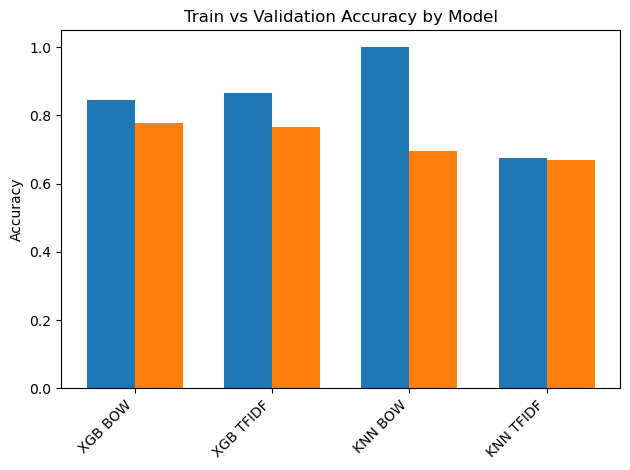

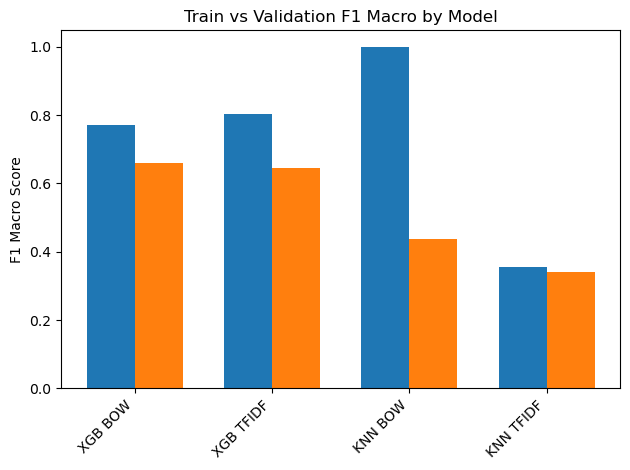

In [13]:
models = ['XGB BOW', 'XGB TFIDF', 'KNN BOW', 'KNN TFIDF']

train_acc = [
    train_accuracy_xboost_bow,
    train_accuracy_xboost_tfidf,
    train_accuracy_knn_bow,
    train_accuracy_knn_tfidf
]
val_acc = [
    val_accuracy_xboost_bow,
    val_accuracy_xboost_tfidf,
    val_accuracy_knn_bow,
    val_accuracy_knn_tfidf
]

train_f1 = [
    train_f1_xboost_bow,
    train_f1_xboost_tfidf,
    train_f1_knn_bow,
    train_f1_knn_tfidf
]
val_f1 = [
    val_f1_xboost_bow,
    val_f1_xboost_tfidf,
    val_f1_knn_bow,
    val_f1_knn_tfidf
]

x = np.arange(len(models))
width = 0.35

# Plot Accuracy
plt.figure()
plt.bar(x - width/2, train_acc, width)
plt.bar(x + width/2, val_acc, width)
plt.xticks(x, models, rotation=45, ha='right')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy by Model')
plt.tight_layout()
plt.show()

# Plot F1 Macro
plt.figure()
plt.bar(x - width/2, train_f1, width)
plt.bar(x + width/2, val_f1, width)
plt.xticks(x, models, rotation=45, ha='right')
plt.ylabel('F1 Macro Score')
plt.title('Train vs Validation F1 Macro by Model')
plt.tight_layout()
plt.show()


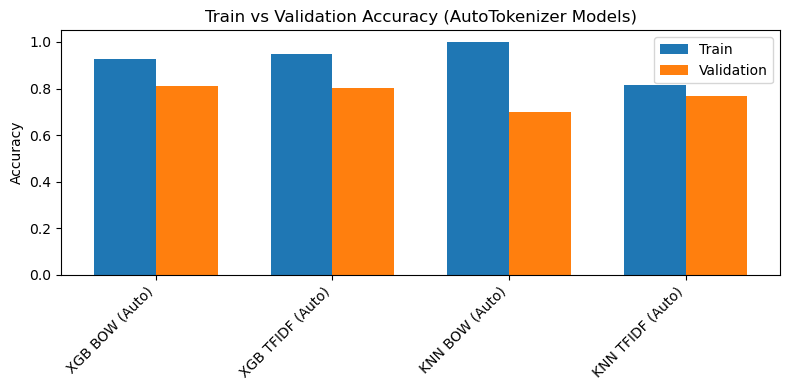

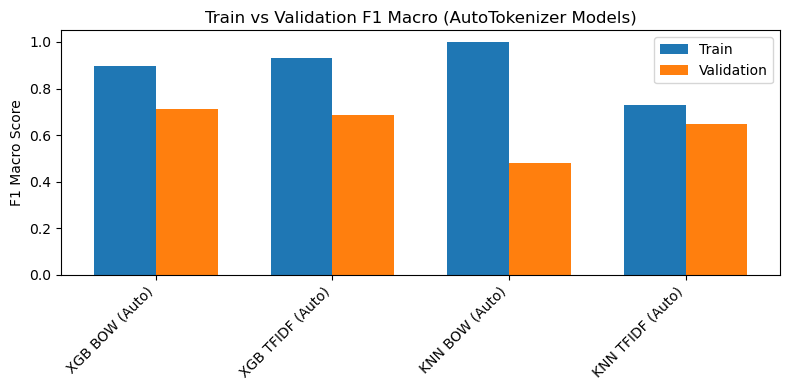

In [14]:
models_auto = [
    'XGB BOW (Auto)', 
    'XGB TFIDF (Auto)', 
    'KNN BOW (Auto)', 
    'KNN TFIDF (Auto)'
]

train_acc_auto = [
    train_accuracy_xboost_bow_autotoken,
    train_accuracy_xboost_tfidf_autotoken,
    train_accuracy_knn_bow_autotoken,
    train_accuracy_knn_tfidf_autotoken
]
val_acc_auto = [
    val_accuracy_xboost_bow_autotoken,
    val_accuracy_xboost_tfidf_autotoken,
    val_accuracy_knn_bow_autotoken,
    val_accuracy_knn_tfidf_autotoken
]

train_f1_auto = [
    train_f1_xboost_bow_autotoken,
    train_f1_xboost_tfidf_autotoken,
    train_f1_knn_bow_autotoken,
    train_f1_knn_tfidf_autotoken
]
val_f1_auto = [
    val_f1_xboost_bow_autotoken,
    val_f1_xboost_tfidf_autotoken,
    val_f1_knn_bow_autotoken,
    val_f1_knn_tfidf_autotoken
]

x = np.arange(len(models_auto))
width = 0.35

# Plot Accuracy for AutoTokenizer models
plt.figure(figsize=(8, 4))
plt.bar(x - width/2, train_acc_auto, width, label='Train')
plt.bar(x + width/2, val_acc_auto,   width, label='Validation')
plt.xticks(x, models_auto, rotation=45, ha='right')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy (AutoTokenizer Models)')
plt.legend()
plt.tight_layout()
plt.show()

# Plot F1 Macro for AutoTokenizer models
plt.figure(figsize=(8, 4))
plt.bar(x - width/2, train_f1_auto, width, label='Train')
plt.bar(x + width/2, val_f1_auto,   width, label='Validation')
plt.xticks(x, models_auto, rotation=45, ha='right')
plt.ylabel('F1 Macro Score')
plt.title('Train vs Validation F1 Macro (AutoTokenizer Models)')
plt.legend()
plt.tight_layout()
plt.show()


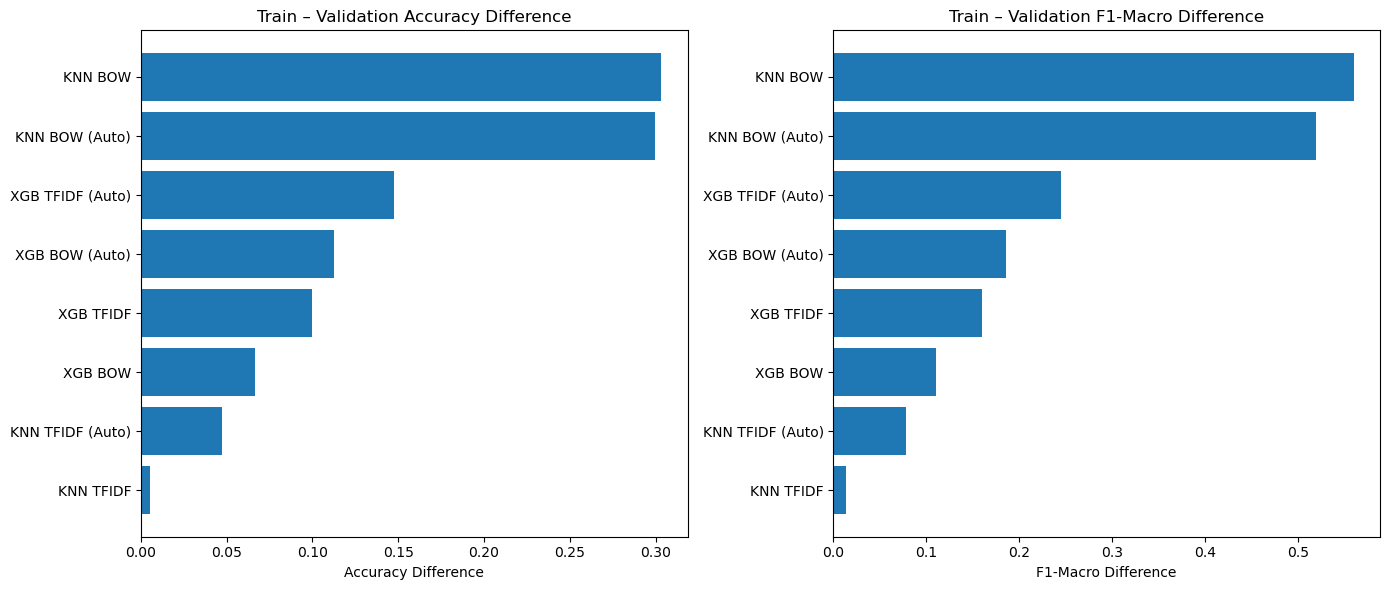

In [16]:
models_all    = models + models_auto
train_acc_all = np.array(train_acc + train_acc_auto)
val_acc_all   = np.array(val_acc   + val_acc_auto)
train_f1_all  = np.array(train_f1  + train_f1_auto)
val_f1_all    = np.array(val_f1    + val_f1_auto)

# Compute differences (train minus validation)
diff_acc = train_acc_all - val_acc_all
diff_f1  = train_f1_all  - val_f1_all

# Sort by descending difference
order_acc = np.argsort(-diff_acc)
order_f1  = np.argsort(-diff_f1)

# Plot side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=False)

# 1) Accuracy difference
axes[0].barh(
    np.array(models_all)[order_acc],
    diff_acc[order_acc]
)
axes[0].set_title('Train – Validation Accuracy Difference')
axes[0].set_xlabel('Accuracy Difference')
axes[0].invert_yaxis()  # largest difference at top

# 2) F1‐macro difference
axes[1].barh(
    np.array(models_all)[order_f1],
    diff_f1[order_f1]
)
axes[1].set_title('Train – Validation F1-Macro Difference')
axes[1].set_xlabel('F1-Macro Difference')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()